In [69]:
import pandas as pd
from datetime import datetime

data = pd.read_csv("../data/dados_ngboost.csv", index_col=0)
data.rename(columns={"pais": "country"}, inplace=True)

data["date"] = data.mes_ano.apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d"))

data.head()

,mes_ano,country,valor,y,lag_horizonte,lag_y_relevante,min_5,max_5,mean_5,median_5,regime_prob,date
1,1991-01-01,Australia,1260.0,-1.254461,8,0.493167,-0.531523,0.978946,0.312905,0.493167,0.122366,1991-01-01
2,1991-02-01,Australia,1160.0,-0.747214,8,-0.246714,-0.531523,0.855935,0.067773,-0.231999,0.221929,1991-02-01
3,1991-02-01,Australia,1160.0,-0.747214,9,0.493167,-0.531523,0.978946,0.312905,0.493167,0.221929,1991-02-01
4,1991-03-01,Australia,1430.0,-0.054398,8,-0.046477,-0.531523,0.855935,0.104877,-0.046477,0.321429,1991-03-01
5,1991-03-01,Australia,1430.0,-0.054398,9,-0.246714,-0.531523,0.855935,0.067773,-0.231999,0.321429,1991-03-01


Singapore (2670, 12)
[iter 0] loss=0.2885 val_loss=0.0000 scale=1.0000 norm=0.6828
[iter 100] loss=-0.2744 val_loss=0.0000 scale=2.0000 norm=0.8660
[iter 200] loss=-0.4689 val_loss=0.0000 scale=2.0000 norm=0.8336
[iter 300] loss=-0.5595 val_loss=0.0000 scale=2.0000 norm=0.8531
[iter 400] loss=-0.6118 val_loss=0.0000 scale=1.0000 norm=0.4304


In [70]:
all_data = data.copy()

# mes_ano, country, valor, y, lag_horizonte, lag_y_relevante, min_5, max_5, mean_5, median_5, regime_prob
X, y = all_data.drop(columns = ["y", "valor", "date", "mes_ano", "country", "lag_horizonte"]), all_data["y"]

train_cut = (all_data.date < datetime(2019, 1, 1))
X_train, X_test, y_train, y_test = (
    X[train_cut],
    X[~train_cut],
    y[train_cut],
    y[~train_cut],
)

ngb = NGBRegressor(random_state=42, validation_fraction = .2)
ngb.fit(X_train, y_train)

[iter 0] loss=0.3980 val_loss=0.0000 scale=1.0000 norm=0.7334
[iter 100] loss=0.2220 val_loss=0.0000 scale=2.0000 norm=1.2903
[iter 200] loss=0.1838 val_loss=0.0000 scale=2.0000 norm=1.2997
[iter 300] loss=0.1638 val_loss=0.0000 scale=1.0000 norm=0.6489
[iter 400] loss=0.1513 val_loss=0.0000 scale=1.0000 norm=0.6489


NGBRegressor(random_state=RandomState(MT19937) at 0x146840D4240)

In [72]:
country = "Hong Kong SAR"

australia_test = data[(data.country == country) & ~train_cut].copy()
australia_test.sort_values(by=["mes_ano", "lag_horizonte"])

select = pd.DataFrame(
    data={
        "date": pd.date_range(
            start=datetime(2019, 1, 1), end=datetime(2019, 12, 1), freq="MS"
        ),
        "lag_horizonte": range(8, 19 + 1),
    }
)

australia_test = pd.merge(
    select, australia_test, on=["date", "lag_horizonte"], how="left"
)

select = pd.DataFrame(
    data = {
        "date": pd.date_range(datetime(2018, 1, 1), end = datetime(2018, 12, 1), freq = "MS"),
    }
)

australia_lag = pd.merge(select, data[data.country == country], on = ["date"], how = "left").drop_duplicates(keep = "first", subset = ["date"])["valor"]
pred = np.exp(ngb.predict(australia_test[X_train.columns])) * australia_lag - 1

sum(abs(australia_test["valor"].values - pred))

16732226.48627308

In [64]:
from ngboost import NGBRegressor
for country, gidxs in data.groupby("country").groups.items():

    group = data.iloc[gidxs]
    print(country, group.shape)

    # mes_ano, country, valor, y, lag_horizonte, lag_y_relevante, min_5, max_5, mean_5, median_5, regime_prob
    X, y = group.drop(columns = ["y", "valor", "date", "mes_ano", "country", "lag_horizonte"]), group["y"]

    train_cut = (group.date < datetime(2019, 1, 1))
    X_train, X_test, y_train, y_test = (
        X[train_cut],
        X[~train_cut],
        y[train_cut],
        y[~train_cut],
    )

    ngb = NGBRegressor(random_state=42, validation_fraction = .2)
    ngb.fit(X_train, y_train)

    break


# class NGBAutoRegressor(NGBRegressor):
#     def multistep(self, X: pd.DataFrame, steps: int):
#         # FIXME assumes SARIMA(1, 0, 0)(1, 0, 0, 12) process
#         pass

Australia (4542, 12)
[iter 0] loss=0.0223 val_loss=0.0000 scale=1.0000 norm=0.6785
[iter 100] loss=-0.3551 val_loss=0.0000 scale=1.0000 norm=0.4869
[iter 200] loss=-0.4300 val_loss=0.0000 scale=1.0000 norm=0.5019
[iter 300] loss=-0.4820 val_loss=0.0000 scale=1.0000 norm=0.5051
[iter 400] loss=-0.5383 val_loss=0.0000 scale=2.0000 norm=0.9820


In [65]:
country = "Australia"

australia_test = data[(data.country == country) & ~train_cut].copy()
australia_test.sort_values(by=["mes_ano", "lag_horizonte"])

select = pd.DataFrame(
    data={
        "date": pd.date_range(
            start=datetime(2019, 1, 1), end=datetime(2019, 12, 1), freq="MS"
        ),
        "lag_horizonte": range(8, 19 + 1),
    }
)

australia_test = pd.merge(
    select, australia_test, on=["date", "lag_horizonte"], how="left"
)

select = pd.DataFrame(
    data = {
        "date": pd.date_range(datetime(2018, 1, 1), end = datetime(2018, 12, 1), freq = "MS"),
    }
)

australia_lag = pd.merge(select, data[data.country == country], on = ["date"], how = "left").drop_duplicates(keep = "first", subset = ["date"])["valor"]
pred = np.exp(ngb.predict(australia_test[X_train.columns])) * australia_lag - 1

sum(abs(australia_test["valor"].values - pred))

174589.7731957896

In [45]:
pd.DataFrame.drop_duplicates?

Signature:
pd.DataFrame.drop_duplicates(
    self,
    subset: 'Hashable | Sequence[Hashable] | None' = None,
    *,
    keep: 'DropKeep' = 'first',
    inplace: 'bool' = False,
    ignore_index: 'bool' = False,
) -> 'DataFrame | None'
Docstring:
Return DataFrame with duplicate rows removed.

Considering certain columns is optional. Indexes, including time indexes
are ignored.

Parameters
----------
subset : column label or sequence of labels, optional
    Only consider certain columns for identifying duplicates, by
    default use all of the columns.
keep : {'first', 'last', ``False``}, default 'first'
    Determines which duplicates (if any) to keep.

    - 'first' : Drop duplicates except for the first occurrence.
    - 'last' : Drop duplicates except for the last occurrence.
    - ``False`` : Drop all duplicates.

inplace : bool, default ``False``
    Whether to modify the DataFrame rather than creating a new one.
ignore_index : bool, default ``False``
    If ``True``, the resultin

In [41]:
from datetime import datetime


data[
        (data.country == "Australia")
        & (
            data.date.isin(
                datetime(2019, 1, 1) - timedelta(months=m) for m in range(1, 12 + 1)
            )
        )
    ]

TypeError: 'months' is an invalid keyword argument for __new__()

In [18]:
import numpy as np

sum((np.exp(ngb.predict(X_test)) - np.exp(y_test)) ** 2) ** .5

327.82568706697475

<Axes: xlabel='y(t-0)', ylabel='y(t+1)'>

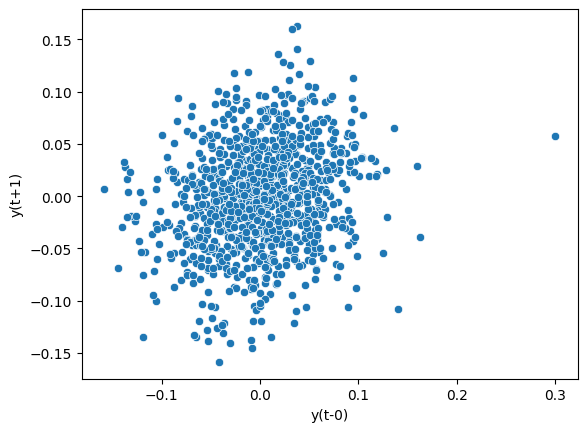

In [9]:
import numpy as np
from tabular_time_series.tsdf import timeseries2df


N = 1_000
x = [.3]
for _ in range(N):
    x.append(.2 * x[-1] + np.random.normal(0, .05))

df = timeseries2df(x, 1, 1)

import seaborn as sns

sns.scatterplot(data = df, x = "y(t-0)", y = "y(t+1)")